# Comparison of models to predict sells

## Introduction 


We try some easy models to predict the sells of "a famous milk company". 
We study the impact of the MAPE metric with some plots.
We'll also try to see the differences between a time model like ARIMA and usual models like XGB,RF or Gradient Boosting. 
Unfortunately, data are private and not acessible.

The data is made of informations about :
- the supermarket seller : Enseigne
- the date of the observations : Week, Year, Date
- the type of product sold : MK1 
- the type of discount : Meca and Pack
- the amount of discount : Plage
- the number of days the discount is in the supermarket : Days_uplifts

Choose the supermarket and the kind of product you would like to predict by filling the following variables :
The product names are :
 - 'F0W'
 - 'F56'
 - 'F8M'
 - 'FHG'
 - 'VR3'
 
The market names are 
- 'Auchan' 
- 'Carrefour'
- 'Carrefour Market'
- 'Casino SM'
- 'Cora'
- 'Geant'
- 'Monoprix'
- 'SM Match  Prospectus'
- 'Systeme U'

If no change, let's assume that we want to stuy the product 'F0W' in the market 'Carrefour Market'

In [591]:
name_market='Carrefour Market'
name_product='F0W'

In [592]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from math import sqrt
import matplotlib
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

In [593]:
df=pd.read_excel('/Users/newuser/Downloads/Waters.xlsx')
df['Date']=pd.to_datetime(df.Year.astype(str), format='%Y') \
+ pd.to_timedelta(df.Week.mul(7).astype(str) + ' days')
df=df.sort_values(by=['Date'])
#df_time=pd.to_datetime(new_df.Year.astype(str), format='%Y') + pd.to_timedelta(new_df.Week.mul(7).astype(str) + ' days')

In [594]:
df.head()

,Client 4,Enseigne,Date,Week,Year,MG1,Sell_Out,Theme,Mecanisme,Pack,Days_Uplifts,Plage
0,Carrefour,Carrefour,2014-01-08,1,2014,FHG,200874.666667,NaN,NaN,NaN,NaN,NaN
25,Eurauchan,Auchan,2014-01-08,1,2014,VR3,117474.000000,NaN,NaN,NaN,NaN,NaN
26,Eurauchan,Auchan,2014-01-08,1,2014,F56,310933.000000,(vide),Lots Virtuels,2 packs,2.0,0.3
27,Eurauchan,Auchan,2014-01-08,1,2014,F8M,146006.000000,NaN,NaN,NaN,NaN,NaN
28,Eurauchan,Auchan,2014-01-08,1,2014,FHG,148510.000000,NaN,NaN,NaN,NaN,NaN


In [595]:
df2=df.drop(['Theme','Client 4'],axis=1)
df2.shape

(8685, 10)

In [596]:
new_df=pd.get_dummies(df2['Enseigne'],prefix='Ens')
new_df2=pd.get_dummies(df2['MG1'],prefix='MG1')
new_df3=pd.get_dummies(df2['Mecanisme'],prefix='Meca',dummy_na=True)
new_df4=pd.get_dummies(df2['Pack'],prefix='Pack',dummy_na=True)

In [597]:
int_df1 = pd.concat([new_df,new_df2],axis=1)
int_df2 = pd.concat([new_df3,new_df4],axis=1)
int_df = pd.concat([int_df1,int_df2],axis=1)
new_df=pd.concat([int_df,df2],axis=1)
new_df.shape
new_df=new_df.drop(['Enseigne','MG1','Mecanisme','Pack'],axis=1)
new_df=new_df.fillna(0)

In [598]:
def analysis_on_one_market_and_one_product(df,name_market,name_product):
    new_df=df[df['Ens_'+name_market]==1]
    new_df=new_df[new_df['MG1_'+name_product]==1]
    new_df=new_df.drop(['Ens_Auchan', 'Ens_Carrefour', 'Ens_Carrefour Market', 'Ens_Casino SM',
       'Ens_Cora', 'Ens_Geant', 'Ens_Monoprix', 'Ens_SM Match  Prospectus',
       'Ens_Systeme U','MG1_F0W', 'MG1_F56', 'MG1_F8M', 'MG1_FHG', 'MG1_VR3'],axis=1)
    return(new_df)

new_df=analysis_on_one_market_and_one_product(new_df,name_market,name_product)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 9 to 8649
Data columns (total 16 columns):
Meca_Cagnottage       193 non-null uint8
Meca_Lots Virtuels    193 non-null uint8
Meca_Multiple         193 non-null uint8
Meca_RI               193 non-null uint8
Meca_nan              193 non-null uint8
Pack_1 pack           193 non-null uint8
Pack_2 packs          193 non-null uint8
Pack_3 packs          193 non-null uint8
Pack_autre            193 non-null uint8
Pack_nan              193 non-null uint8
Date                  193 non-null datetime64[ns]
Week                  193 non-null int64
Year                  193 non-null int64
Sell_Out              193 non-null float64
Days_Uplifts          193 non-null float64
Plage                 193 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(2), uint8(10)
memory usage: 12.4 KB


In [599]:
new_df=new_df.sort_values(by='Date')
new_df.index=new_df['Date']
new_df=new_df.drop('Date',axis=1)
Y=new_df['Sell_Out']

In [600]:
new_df.head()

,Meca_Cagnottage,Meca_Lots Virtuels,Meca_Multiple,Meca_RI,Meca_nan,Pack_1 pack,Pack_2 packs,Pack_3 packs,Pack_autre,Pack_nan,Week,Year,Sell_Out,Days_Uplifts,Plage
Date,,,,,,,,,,,,,,,
2014-01-08,0,0,0,0,1,0,0,0,0,1,1,2014,229458.666667,0.0,0.0
2014-01-15,0,0,0,0,1,0,0,0,0,1,2,2014,242696.000000,0.0,0.0
2014-01-22,0,0,0,0,1,0,0,0,0,1,3,2014,226044.666667,0.0,0.0
2014-01-29,0,0,0,0,1,0,0,0,0,1,4,2014,228367.333333,0.0,0.0
2014-02-05,0,0,0,0,1,0,0,0,0,1,5,2014,256786.000000,0.0,0.0


In [601]:
new_df_train=new_df[new_df['Year']<2017]
new_df_test=new_df[new_df['Year']>=2017]
Y_train=new_df_train['Sell_Out']
Y_test=new_df_test['Sell_Out']
new_df_train=new_df_train.drop('Sell_Out',axis=1)
new_df_test=new_df_test.drop('Sell_Out',axis=1)
new_df_train.head()
index_train=new_df_train.index
index_test=new_df_test.index
index_train.summary()

'DatetimeIndex: 157 entries, 2014-01-08 to 2016-12-30'

Lets predict the 2017 sells, training the model with the 2014-2016 sells

In [602]:
rfg=RandomForestRegressor(n_estimators=10, criterion='mae')
rfg_fitted=rfg.fit(new_df_train,Y_train)

In [603]:
from sklearn import metrics
def rmse(predictions,true_y):
    return(np.sqrt(((predictions - true_y) ** 2).mean()))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

---------On test set---------
RMSE = 132081.2313462164
MAPE = 17.602906604742135
MAE= 78602.33888888863
MSE= 17445451673.932735
R2= 0.8439452932078243


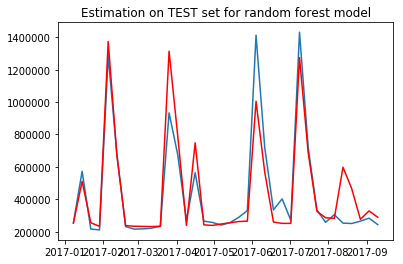

In [604]:
y_pred=rfg_fitted.predict(new_df_test)
print('---------On test set---------')

print('RMSE = {}'.format(rmse(y_pred,Y_test)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_test, y_pred)))

pyplot.plot(Y_test)
pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
pyplot.title('Estimation on TEST set for random forest model')
pyplot.show()

---------On train set---------
RMSE = 78466.84152960223
MAPE = 8.480511097187037
MAE= 34774.54033970273
MSE= 6157045219.631707
R2= 0.9031486130927615


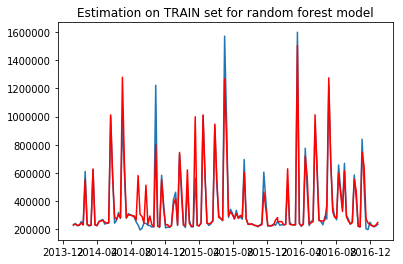

In [606]:
y_pred=rfg_fitted.predict(new_df_train)
print('---------On train set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_train)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_train, y_pred)))

pyplot.plot(Y_train)
pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
pyplot.title('Estimation on TRAIN set for random forest model')
pyplot.show()

In [607]:
df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':rfg_fitted.feature_importances_})
df_var_importance.sort_values(by=['score (the higher the better)'])

,name_variable,score (the higher the better)
2,Meca_Multiple,0.000000
8,Pack_autre,0.000000
4,Meca_nan,0.000018
9,Pack_nan,0.000090
3,Meca_RI,0.000965
7,Pack_3 packs,0.005991
5,Pack_1 pack,0.017719
1,Meca_Lots Virtuels,0.020008
0,Meca_Cagnottage,0.020646
6,Pack_2 packs,0.048778


This Data Frame tells us what variables have the biggest impact on the predictions. The Week variable influence a lot our results, because it allows to distinguish holidays, or religious event like christmas, where the sells can vary a lot. 
Moreover, in the Carrefour and Systeme U markets, the choice of the kind of discounts will affect the amount of sells more than in the other markets. 
The variable "Pack" is not very helpful for this model.

In [608]:
from sklearn.ensemble import GradientBoostingRegressor

In [609]:
GBR=GradientBoostingRegressor(loss='lad',n_estimators=100)
GBR_fitted=GBR.fit(new_df_train,Y_train)

---------On test set---------
RMSE = 194420.22559060605
MAPE = 19.560518695380186
MAE= 100782.97904314195
MSE= 37799224118.70215
R2= 0.66187479997266


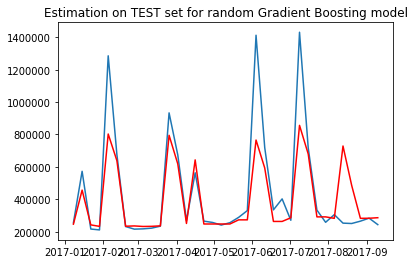

In [610]:
y_pred=GBR_fitted.predict(new_df_test)
print('---------On test set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_test)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_test, y_pred)))

pyplot.plot(Y_test)
pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
pyplot.title('Estimation on TEST set for random Gradient Boosting model')
pyplot.show()

---------On train set---------
RMSE = 130191.33252433689
MAPE = 10.355464828486822
MAE= 52211.74585579366
MSE= 16949783064.462461
R2= 0.7333769788898502


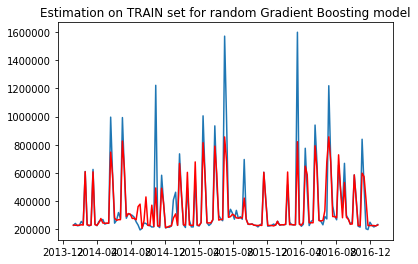

In [611]:
y_pred=GBR_fitted.predict(new_df_train)
print('---------On train set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_train)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_train, y_pred)))

pyplot.plot(Y_train)
pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
pyplot.title('Estimation on TRAIN set for random Gradient Boosting model')
pyplot.show()

In [612]:
df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':GBR_fitted.feature_importances_})
df_var_importance.sort_values(by=['score (the higher the better)'])

,name_variable,score (the higher the better)
2,Meca_Multiple,0.000000
8,Pack_autre,0.000000
9,Pack_nan,0.001241
5,Pack_1 pack,0.002063
3,Meca_RI,0.002858
7,Pack_3 packs,0.002932
4,Meca_nan,0.003598
1,Meca_Lots Virtuels,0.009688
6,Pack_2 packs,0.022066
0,Meca_Cagnottage,0.038905


In [613]:
import xgboost

In [614]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [615]:
xgb_fitted=xgb.fit(new_df_train,Y_train)

---------On test set---------
RMSE = 131895.77740764152
MAPE = 17.939353178732656
MAE= 76940.52445023136
MSE= 17396496097.966118
R2= 0.8443832152631602


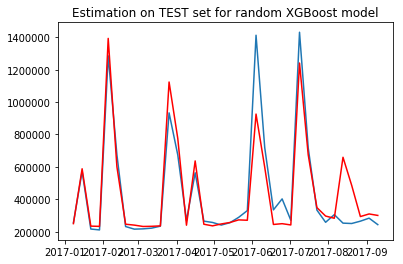

In [616]:
y_pred=xgb_fitted.predict(new_df_test)
print('---------On test set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_test)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_test, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_test, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_test, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_test, y_pred)))

pyplot.plot(Y_test)
pyplot.plot(pd.DataFrame(index=index_test, data=y_pred), color='red')
pyplot.title('Estimation on TEST set for random XGBoost model')
pyplot.show()

---------On train set---------
RMSE = 12459.456552495445
MAPE = 2.169060460919431
MAE= 7587.311206210153
MSE= 155238057.5835217
R2= 0.9975580784870947


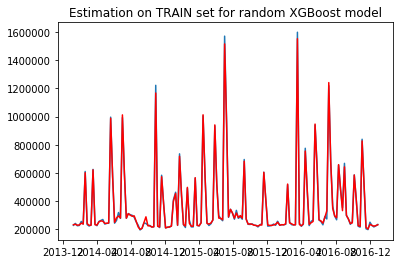

In [617]:
y_pred=xgb_fitted.predict(new_df_train)
print('---------On train set---------')
print('RMSE = {}'.format(rmse(y_pred,Y_train)))
print('MAPE = {}'.format(mean_absolute_percentage_error(Y_train, y_pred)))
print('MAE= {}'.format(metrics.mean_absolute_error(Y_train, y_pred)))
print('MSE= {}'.format(metrics.mean_squared_error(Y_train, y_pred)))
print('R2= {}'.format(metrics.r2_score(Y_train, y_pred)))

pyplot.plot(Y_train)
pyplot.plot(pd.DataFrame(index=index_train, data=y_pred), color='red')
pyplot.title('Estimation on TRAIN set for random XGBoost model')
pyplot.show()

In [618]:
df_var_importance=pd.DataFrame({'name_variable':new_df.drop('Sell_Out',axis=1).columns,'score (the higher the better)':xgb_fitted.feature_importances_})
df_var_importance.sort_values(by=['score (the higher the better)'])

,name_variable,score (the higher the better)
2,Meca_Multiple,0.000000
8,Pack_autre,0.000000
9,Pack_nan,0.000000
3,Meca_RI,0.000903
4,Meca_nan,0.001807
7,Pack_3 packs,0.003312
6,Pack_2 packs,0.018669
13,Plage,0.033725
5,Pack_1 pack,0.048479
0,Meca_Cagnottage,0.052394


# Conslusion :

 A first conclusion can be made about the non effectiveness of the MAPE metric to estimate the accuracy of the model and can be seen thanks to the graph of test prediction of sells.